In [211]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
#from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications import VGG16

import os
import numpy as np
import matplotlib.pyplot as plt

In [212]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [213]:
base = 'cats_and_dogs'

In [214]:
train_images = os.path.join(base, 'train')
validation_images = os.path.join(base, 'validation')

In [215]:
train_images_cats = os.path.join(train_images, 'cats')
train_images_dogs = os.path.join(train_images, 'dogs')
validation_images_cats = os.path.join(validation_images, 'cats')
validation_images_dogs = os.path.join(validation_images, 'dogs')

In [216]:
num_cats_tr = len(os.listdir(train_images_cats))
num_dogs_tr = len(os.listdir(train_images_dogs))
num_cats_val = len(os.listdir(validation_images_cats))
num_dogs_val = len(os.listdir(validation_images_dogs))

In [217]:
total_train = num_cats_tr + num_dogs_tr
total_validation = num_cats_val + num_dogs_val

In [218]:
BATCH_SIZE = 32
IMG_SHAPE = 150

In [219]:
#feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
#pretrained_model_without_top_layer = hub.KerasLayer(feature_extractor_model,
#                                                    input_shape=(IMG_SHAPE,IMG_SHAPE,3),
#                                                    trainable=False)

In [220]:
#conv_base = VGG16(weights='imagenet', include_top=False,
#                  input_shape=(IMG_SHAPE,IMG_SHAPE,3))
#conv_base.trainable = False

In [221]:
conv_base = keras.applications.Xception(weights='imagenet', include_top=False,
                  input_shape=(IMG_SHAPE,IMG_SHAPE,3))
conv_base.trainable = False

In [222]:
train_images_generator = ImageDataGenerator(rescale=1./255, #rescalar
                                            rotation_range=40, #rotacionar imagem
                                            width_shift_range=0.2,
                                            height_shift_range=0.2,
                                            shear_range=0.2, #cisalhamento
                                            zoom_range=0.2, #zoom
                                            horizontal_flip=True, #inverter horizontalmente
                                            fill_mode='nearest')


validation_images_generator = ImageDataGenerator(rescale=1./255)


In [223]:
train_data_gen = train_images_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                            directory=train_images,
                                                            shuffle=True,
                                                            target_size=(IMG_SHAPE,IMG_SHAPE),
                                                            class_mode='binary'
                                                           )

validation_data_gen = validation_images_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                            directory=validation_images,
                                                            shuffle=False,
                                                            target_size=(IMG_SHAPE,IMG_SHAPE),
                                                            class_mode='binary'
                                                           )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [224]:
train_data_gen.class_indices

{'cats': 0, 'dogs': 1}

In [225]:
validation_data_gen.class_indices

{'cats': 0, 'dogs': 1}

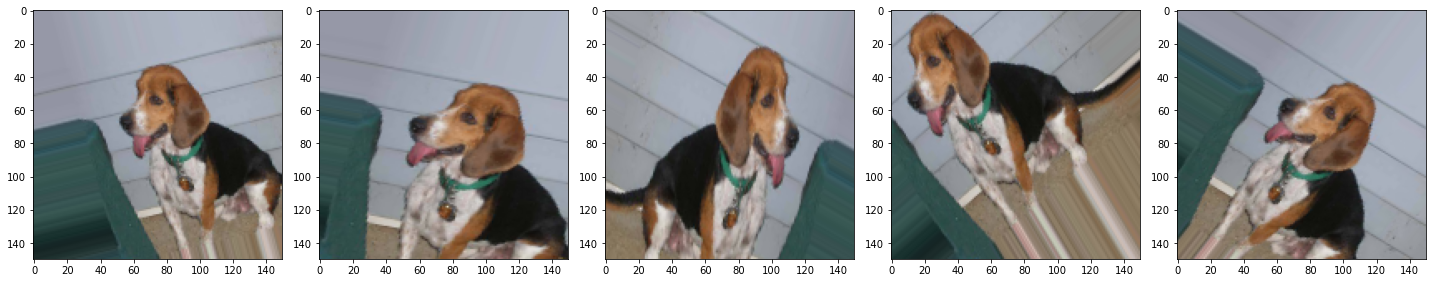

In [226]:
images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(images)

In [227]:
model = keras.models.Sequential([
    conv_base,
    
    keras.layers.GlobalAveragePooling2D(),
    
    keras.layers.Flatten(),

    keras.layers.Dense(1024, activation='relu'),

    keras.layers.Dense(2, activation='softmax')
                         
])

In [228]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [229]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 2050      
Total params: 22,961,706
Trainable params: 2,100,226
Non-trainable params: 20,861,480
_________________________________________________________________


In [230]:
EPOCHS = 5

In [231]:
history = model.fit_generator(train_data_gen, 
                              steps_per_epoch = int(np.ceil(total_train / float(BATCH_SIZE))),
                              epochs=EPOCHS,
                              validation_data=validation_data_gen, 
                              validation_steps = int(np.ceil(total_validation / float(BATCH_SIZE)))
                              )

Epoch 1/5
63/63 [==============================] - 65s 1s/step - loss: 0.3173 - accuracy: 0.8860 - val_loss: 0.0896 - val_accuracy: 0.9630
Epoch 2/5
63/63 [==============================] - 66s 1s/step - loss: 0.1527 - accuracy: 0.9390 - val_loss: 0.0822 - val_accuracy: 0.9650
Epoch 3/5
63/63 [==============================] - 66s 1s/step - loss: 0.1374 - accuracy: 0.9430 - val_loss: 0.0892 - val_accuracy: 0.9620
Epoch 4/5
63/63 [==============================] - 69s 1s/step - loss: 0.1376 - accuracy: 0.9380 - val_loss: 0.1984 - val_accuracy: 0.9360
Epoch 5/5
63/63 [==============================] - 67s 1s/step - loss: 0.1463 - accuracy: 0.9365 - val_loss: 0.0877 - val_accuracy: 0.9670


In [232]:
model.save("cats_and_dogs_modelTL.h5")

In [233]:
# analysis
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

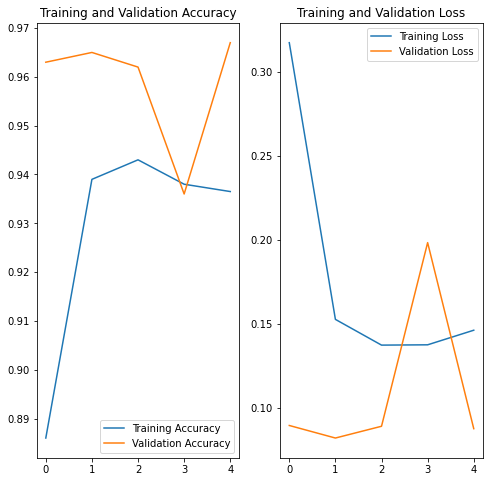

In [234]:
epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [235]:
#fazer predições
test_images = os.path.join(base, 'test')
test_dogs_images = os.path.join(test_images, 'dogs')
test_cats_images = os.path.join(test_images, 'cats')

In [236]:
test_images_generator = ImageDataGenerator(rescale=1./255)

In [237]:
test_data_gen = test_images_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                            directory=test_images,
                                                            shuffle=False,
                                                            target_size=(IMG_SHAPE,IMG_SHAPE),
                                                            class_mode='binary'
                                                           )

Found 2000 images belonging to 2 classes.


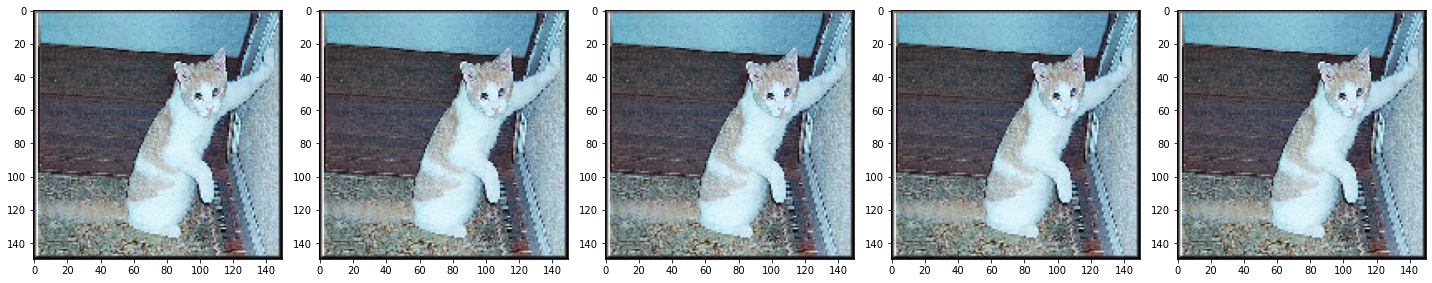

In [238]:
images = [test_data_gen[0][0][0] for i in range(5)]
plotImages(images)

In [239]:
prediction_probabilities = model.predict_generator(test_data_gen, verbose=1)


63/63 [==============================] - 44s 695ms/step


In [240]:
contGatos = 0
contCacho = 0
for i in range(0,len(prediction_probabilities)):
    if i < 1000:
        if np.argmax(prediction_probabilities[i]) == 0:
            contGatos += 1
    else:
        if np.argmax(prediction_probabilities[i]) == 1:
            contCacho += 1

In [241]:
print('Gatos:',(contGatos/1000)*100,'%')
print('Cachorros:',(contCacho/1000)*100,'%')

Gatos: 98.4 %
Cachorros: 94.69999999999999 %


In [242]:
#os.listdir(test_images)

In [243]:
#contCorretos = 0
#for i in os.listdir(test_dogs_images):
#    patch_image = os.path.join(test_dogs_images, i)
 #   test_data_gen = image.load_img(patch_image, target_size=(IMG_SHAPE,IMG_SHAPE))
    
  #  img_array = image.img_to_array(test_data_gen)/255
   # img_batch = np.expand_dims(img_array, axis=0)
    
    #img_preprocessed = preprocess_input(img_batch)
    
    #prediction = model.predict(img_batch)
    #print(np.argmax(prediction[0]))
    #print(prediction)
    
   # if np.argmax(prediction[0]) == 1:
    #    contCorretos += 1

In [244]:
#prediction[0].dtype

In [245]:
#acertos = contCorretos/len(os.listdir(test_dogs_images))
#print("Taxa de acerto dos dogs:", acertos)

In [246]:
#len(os.listdir(test_dogs_images))

In [247]:
#contCorretosCats = 0
#for i in os.listdir(test_cats_images):
#    patch_image = os.path.join(test_cats_images, i)
 #   test_data_gen = image.load_img(patch_image, target_size=(IMG_SHAPE,IMG_SHAPE))
    
  #  img_array = image.img_to_array(test_data_gen)/255
   # img_batch = np.expand_dims(img_array, axis=0)
    
    #img_preprocessed = preprocess_input(img_batch)
    
    #prediction = model.predict(img_batch)
    #print(np.argmax(prediction[0]))
    #print(prediction)
    #if np.argmax(prediction[0]) == 0:
     #   contCorretosCats += 1

In [248]:
#acertosCats = contCorretosCats/len(os.listdir(test_cats_images))
#print("Taxa de acerto dos cats:", acertosCats)

In [249]:
#np.argmax(prediction[0])

In [250]:
#print("Taxa de acertos total:", (contCorretosCats+contCorretos)/(len(os.listdir(test_cats_images))+len(os.listdir(test_dogs_images))))